In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install unrar
!unrar x "/content/drive/MyDrive/datasets/Face_Mask_Dataset.rar" "/content/"


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/drive/MyDrive/datasets/Face_Mask_Dataset.rar


Would you like to replace the existing file /content/Face Mask Dataset/Test/WithMask/1163.png
  3336 bytes, modified on 2020-05-26 00:23
with a new one
  3336 bytes, modified on 2020-05-26 00:23

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit Q

Program aborted


In [ ]:
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision.models as models
import pathlib
import torchvision

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
print(device)

cuda


In [ ]:
transformer = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [ ]:
train = '/content/Face_Mask_Dataset/Train'
test = '/content/Face_Mask_Dataset/Test'
val = '/content/Face_Mask_Dataset/Validation'
train_loader = DataLoader(
    torchvision.datasets.ImageFolder(train, transform=transformer),
    batch_size=64, shuffle=True
)

test_loader = DataLoader(
    torchvision.datasets.ImageFolder(test, transform=transformer),
    batch_size=64, shuffle=True
)

val_loader = DataLoader(
    torchvision.datasets.ImageFolder(val, transform=transformer),
    batch_size=64, shuffle=True
)

In [ ]:
root = pathlib.Path(train)
classes = sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [ ]:
print(classes)

['WithMask', 'WithoutMask']


In [ ]:
model = models.vgg19(pretrained=True)  # For VGG19

# Freeze the parameters
for param in model.parameters():
    param.requires_grad = False

# Modify the classifier to match your number of classes
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, len(classes))

model = model.to(device)

optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
loss_function = nn.CrossEntropyLoss()

num_epochs = 10

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 82.0MB/s]


In [ ]:
train_count = len(glob.glob(train + '/**/*.png'))
test_count = len(glob.glob(test + '/**/*.png'))

In [ ]:
print(train_count, test_count)

10000 992


Epoch: 0 Train Loss: 0.007057139300898416 Train Accuracy: 0.9972 Test Accuracy: 0.9979838709677419
Epoch: 1 Train Loss: 0.007957668236314839 Train Accuracy: 0.9968 Test Accuracy: 0.9959677419354839
Epoch: 2 Train Loss: 0.00618957524355501 Train Accuracy: 0.9978 Test Accuracy: 0.9979838709677419
Epoch: 3 Train Loss: 0.009072487022516725 Train Accuracy: 0.9971 Test Accuracy: 0.9969758064516129
Epoch: 4 Train Loss: 0.007681767856454644 Train Accuracy: 0.9973 Test Accuracy: 0.9969758064516129
Epoch: 5 Train Loss: 0.008056177797430428 Train Accuracy: 0.9973 Test Accuracy: 0.9969758064516129
Epoch: 6 Train Loss: 0.007151120501125115 Train Accuracy: 0.9977 Test Accuracy: 0.9959677419354839
Epoch: 7 Train Loss: 0.003429545878679346 Train Accuracy: 0.9985 Test Accuracy: 0.9979838709677419
Epoch: 8 Train Loss: 0.0054842801964608955 Train Accuracy: 0.9977 Test Accuracy: 0.9969758064516129
Epoch: 9 Train Loss: 0.00407703356930233 Train Accuracy: 0.9987 Test Accuracy: 0.9979838709677419


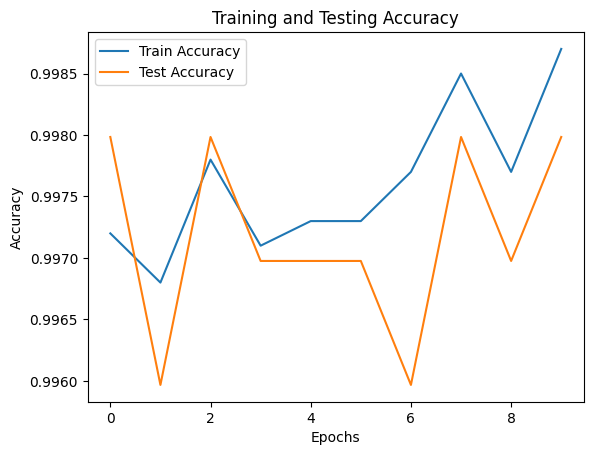

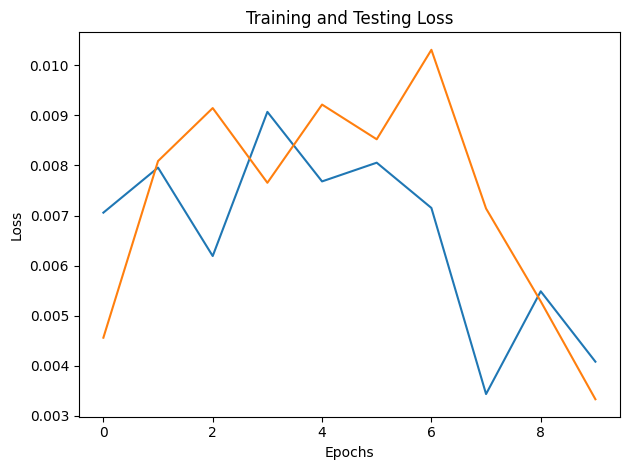

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
# (Assuming you have defined your custom model, loss function, and data loaders)

# Lists to store accuracy and loss values
train_accuracy_values = []
test_accuracy_values = []
train_loss_values = []
test_loss_values = []
best_accuracy = 0.0

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_accuracy = 0.0
    train_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, prediction = torch.max(outputs.data, 1)
        train_accuracy += int(torch.sum(prediction == labels.data))

    # Calculate final training accuracy for the epoch
    train_accuracy = train_accuracy / train_count
    train_loss = train_loss / train_count

    # Evaluation loop
    model.eval()
    test_accuracy = 0.0
    test_loss = 0.0

    # Ensure test_loss calculation is included
    with torch.no_grad():  # Disable gradient calculation for efficiency
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, prediction = torch.max(outputs.data, 1)
            test_accuracy += int(torch.sum(prediction == labels.data))
            # Calculate test loss within the evaluation loop
            test_loss += loss_function(outputs, labels).item() * images.size(0)

    # Calculate final testing accuracy for the epoch
    test_accuracy = test_accuracy / test_count
    test_loss = test_loss / test_count

    train_accuracy_values.append(train_accuracy)
    test_accuracy_values.append(test_accuracy)
    train_loss_values.append(train_loss)
    test_loss_values.append(test_loss)

    print('Epoch: ' + str(epoch) + ' Train Loss: ' + str(train_loss) + ' Train Accuracy: ' + str(
        train_accuracy) + ' Test Accuracy: ' + str(test_accuracy))

    if test_accuracy > best_accuracy:
        torch.save(model.state_dict(), 'best_checkpoint.model')
        best_accuracy = test_accuracy

# Plotting the accuracies (unchanged)
plt.plot(range(num_epochs), train_accuracy_values, label='Train Accuracy')
plt.plot(range(num_epochs), test_accuracy_values, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()
plt.show()

# Plotting the loss (unchanged)
plt.plot(range(num_epochs), train_loss_values, label='Train Loss')
plt.plot(range(num_epochs), test_loss_values, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.tight_layout()
plt.show()


In [ ]:
model = models.vgg16(pretrained=True)  # For VGG16

# Freeze the parameters
for param in model.parameters():
    param.requires_grad = False

# Modify the classifier to match your number of classes
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, len(classes))

model = model.to(device)

optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
loss_function = nn.CrossEntropyLoss()

num_epochs = 10

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 113MB/s]


Epoch: 0 Train Loss: 0.040894450547546146 Train Accuracy: 0.9855 Test Accuracy: 0.9929435483870968
Epoch: 1 Train Loss: 0.015211157651618123 Train Accuracy: 0.995 Test Accuracy: 0.9939516129032258
Epoch: 2 Train Loss: 0.014168027992872522 Train Accuracy: 0.9948 Test Accuracy: 0.9969758064516129
Epoch: 3 Train Loss: 0.01233305031703785 Train Accuracy: 0.9954 Test Accuracy: 0.9969758064516129
Epoch: 4 Train Loss: 0.00921593607692048 Train Accuracy: 0.9967 Test Accuracy: 0.9969758064516129
Epoch: 5 Train Loss: 0.009958579199155793 Train Accuracy: 0.9966 Test Accuracy: 0.9979838709677419
Epoch: 6 Train Loss: 0.010144552658987232 Train Accuracy: 0.996 Test Accuracy: 0.9979838709677419
Epoch: 7 Train Loss: 0.011037383669847623 Train Accuracy: 0.9959 Test Accuracy: 0.9959677419354839
Epoch: 8 Train Loss: 0.010070159798348322 Train Accuracy: 0.9961 Test Accuracy: 0.9979838709677419
Epoch: 9 Train Loss: 0.01022557847709395 Train Accuracy: 0.9964 Test Accuracy: 0.9969758064516129


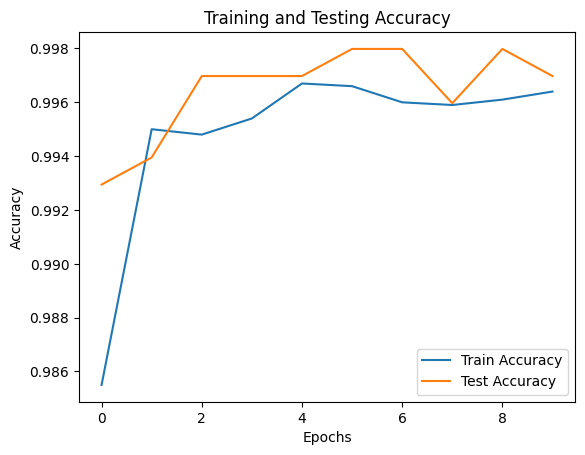

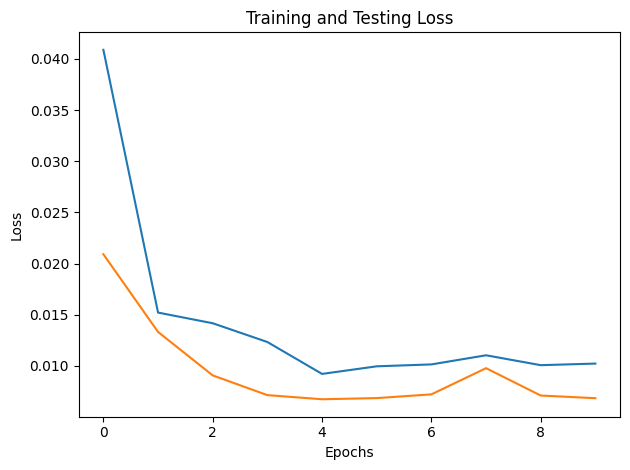

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
# (Assuming you have defined your custom model, loss function, and data loaders)

# Lists to store accuracy and loss values
train_accuracy_values = []
test_accuracy_values = []
train_loss_values = []
test_loss_values = []
best_accuracy = 0.0

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_accuracy = 0.0
    train_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, prediction = torch.max(outputs.data, 1)
        train_accuracy += int(torch.sum(prediction == labels.data))

    # Calculate final training accuracy for the epoch
    train_accuracy = train_accuracy / train_count
    train_loss = train_loss / train_count

    # Evaluation loop
    model.eval()
    test_accuracy = 0.0
    test_loss = 0.0

    # Ensure test_loss calculation is included
    with torch.no_grad():  # Disable gradient calculation for efficiency
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, prediction = torch.max(outputs.data, 1)
            test_accuracy += int(torch.sum(prediction == labels.data))
            # Calculate test loss within the evaluation loop
            test_loss += loss_function(outputs, labels).item() * images.size(0)

    # Calculate final testing accuracy for the epoch
    test_accuracy = test_accuracy / test_count
    test_loss = test_loss / test_count

    train_accuracy_values.append(train_accuracy)
    test_accuracy_values.append(test_accuracy)
    train_loss_values.append(train_loss)
    test_loss_values.append(test_loss)

    print('Epoch: ' + str(epoch) + ' Train Loss: ' + str(train_loss) + ' Train Accuracy: ' + str(
        train_accuracy) + ' Test Accuracy: ' + str(test_accuracy))

    if test_accuracy > best_accuracy:
        torch.save(model.state_dict(), 'best_checkpoint.model')
        best_accuracy = test_accuracy

# Plotting the accuracies (unchanged)
plt.plot(range(num_epochs), train_accuracy_values, label='Train Accuracy')
plt.plot(range(num_epochs), test_accuracy_values, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()
plt.show()

# Plotting the loss (unchanged)
plt.plot(range(num_epochs), train_loss_values, label='Train Loss')
plt.plot(range(num_epochs), test_loss_values, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.tight_layout()
plt.show()


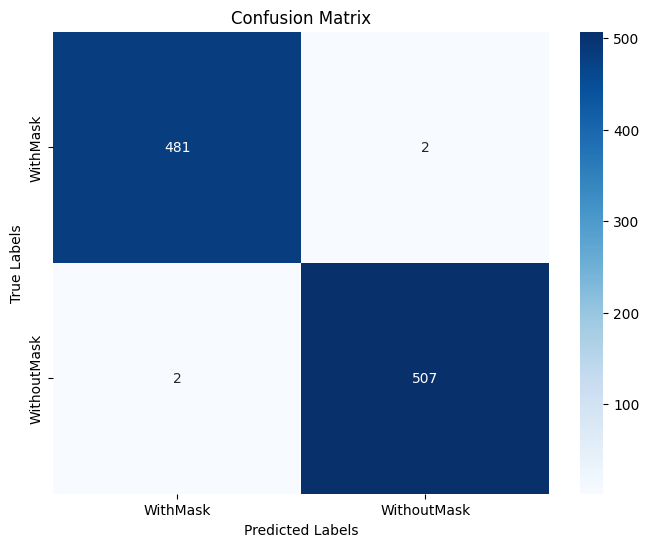

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Function to get predictions and true labels
def get_predictions(model, data_loader):
    model.eval()
    predictions = []
    true_labels = []
    for images, labels in data_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
    return predictions, true_labels

# Get predictions for test data
test_predictions, test_labels = get_predictions(model, test_loader)

# Generate confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


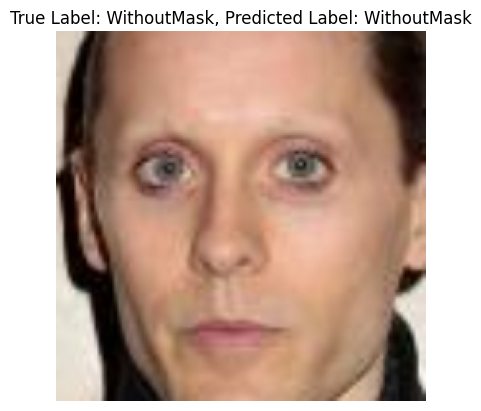

In [ ]:
import random
import matplotlib.pyplot as plt

# Load the trained model
model.load_state_dict(torch.load('best_checkpoint.model'))
model.eval()

# Move model to the same device as the input data
model = model.to(device)

# Select a random image from the test dataset
random_image_index = random.randint(0, len(test_loader.dataset) - 1)
random_image, true_label = test_loader.dataset[random_image_index]
random_image = random_image.unsqueeze(0).to(device)  # Add batch dimension and move to device

# Forward pass through the model
with torch.no_grad():
    output = model(random_image)
    predicted_class = torch.argmax(output).item()

# Convert class index to class label
predicted_label = classes[predicted_class]

# Denormalize and display the image
denormalize = transforms.Compose([
    transforms.Normalize(mean=[-1, -1, -1], std=[2, 2, 2]),
    transforms.ToPILImage()
])
image = denormalize(random_image.squeeze()).convert("RGB")
plt.imshow(image)
plt.axis('off')
plt.title(f"True Label: {classes[true_label]}, Predicted Label: {predicted_label}")
plt.show()
